In [2]:
device = 'cuda'

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [4]:
data = np.load('dataset/terrain_dataset.npy').astype(np.float32)

data -= np.mean(data)
data /= np.std(data)

data = torch.from_numpy(data).float()
data = data.view(-1, 1, 64, 64)
dataset = torch.utils.data.TensorDataset(data)
train, test = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
print(data.shape)


torch.Size([65349, 1, 64, 64])


In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            # (1) x 64 x 64
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (32) x 32 x 32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (64) x 16 x 16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (128) x 8 x 8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (256) x 4 x 4
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, latent_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.main(x)

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            # (256) x 4 x 4
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (128) x 8 x 8
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (64) x 16 x 16
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (32) x 32 x 32
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # (1) x 64 x 64
        )
    
    def forward(self, x):
        return self.main(x)

In [10]:
encoder = Encoder(latent_dim=512).to(device)
decoder = Decoder(latent_dim=512).to(device)
criterion = nn.MSELoss()

### Train the Autoencoder

In [11]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0002)

for epoch in range(10):
    for i, data in enumerate(train_loader):
        data = data[0].to(device)

        optimizer.zero_grad()

        latent = encoder(data)
        output = decoder(latent)

        loss = criterion(output, data)
        loss.backward()
        
        optimizer.step()

        print(f'Epoch {epoch}, Batch {i}, Loss {loss.item()}')

Epoch 0, Batch 0, Loss 2.0084900856018066
Epoch 0, Batch 1, Loss 1.4402985572814941
Epoch 0, Batch 2, Loss 1.1652421951293945
Epoch 0, Batch 3, Loss 1.083646535873413
Epoch 0, Batch 4, Loss 1.3505425453186035
Epoch 0, Batch 5, Loss 1.4816290140151978
Epoch 0, Batch 6, Loss 0.6512320041656494
Epoch 0, Batch 7, Loss 0.8611530065536499
Epoch 0, Batch 8, Loss 0.9708590507507324
Epoch 0, Batch 9, Loss 0.7268757820129395
Epoch 0, Batch 10, Loss 0.5625356435775757
Epoch 0, Batch 11, Loss 0.5708572864532471
Epoch 0, Batch 12, Loss 0.6764288544654846
Epoch 0, Batch 13, Loss 0.6494113802909851
Epoch 0, Batch 14, Loss 0.37608975172042847
Epoch 0, Batch 15, Loss 0.8315567970275879
Epoch 0, Batch 16, Loss 0.2335222065448761
Epoch 0, Batch 17, Loss 0.3904922604560852
Epoch 0, Batch 18, Loss 0.43105173110961914
Epoch 0, Batch 19, Loss 0.4177207052707672
Epoch 0, Batch 20, Loss 0.523215115070343
Epoch 0, Batch 21, Loss 0.6350269317626953
Epoch 0, Batch 22, Loss 0.47194719314575195
Epoch 0, Batch 23, L

### View an example input and output

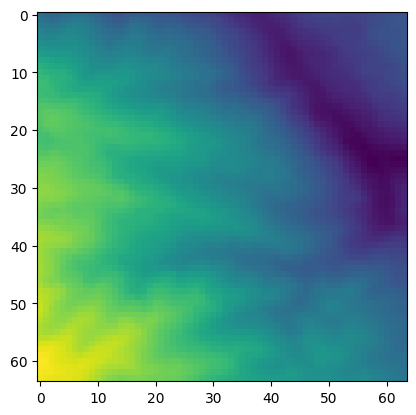

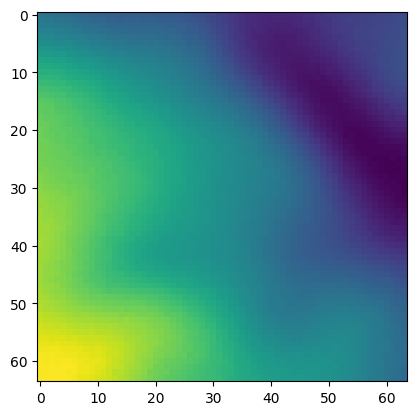

In [12]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    data = next(iter(test_loader))[0].to(device)
    latent = encoder(data)
    output = decoder(latent)

    data = data.cpu().numpy()
    output = output.cpu().numpy()

    plt.imshow(data[0, 0])
    plt.show()
    plt.imshow(output[0, 0])
    plt.show()